<img src='./img/LogoWekeo_Copernicus_RGB_0.png' align='right' width='20%'></img>

# Tutorial on basic land applications (data processing) Version 2

In this tutorial we will use the WEkEO Jupyterhub to access and analyse data from the Copernicus Sentinel-2 and products from the [Copernicus Land Monitoring Service (CLMS)](https://land.copernicus.eu/). 
A region in northern Corsica has been selected as it contains representative landscape features and process elements which can be used to demonstrate the capabilities and strengths of Copernicus space component and services.
The tutorial comprises the following steps:
1. Search and download data: We will select and download a Sentinel-2 scene and the CLMS CORINE Land Cover (CLC) data from their original archive locations via WEkEO using the Harmonised Data Access (HAD) API.
2.	[Read and view Sentinel-2 data](#load_sentinel2): Once downloaded, we will read and view the Sentinel-2 data in geographic coordinates as true colour image.
3.	[Process and view Sentinel-2 data as a vegetation and other spectral indices](#sentinel2_ndvi): We will see how the vegetation density and health can be assessed from optical EO data to support crop and landscape management practices.
4.	[Read and view the CLC data](#display_clc): Display the thematic CLC data with the correct legend.
5.	[CLC2018 burnt area in the Sentinel-2 NDVI data](#CLC_burn_NDVI): The two products give different results, but they can be combined to provide more information.

NOTE - This Jupyter Notebook contains additonal processing to demonstrate further functionality during the training debrief.

<img src='./img/Intro_banner.jpg' align='center' width='100%'></img>

## <a id='load_sentinel2'></a>2. Load required Sentinel-2 bands and True Color image at 10 m spatial resolution

Before we begin we must prepare our environment. This includes importing the various python libraries that we will need.

### Load required libraries

In [1]:
import os
import rasterio as rio
from rasterio import plot
from rasterio.mask import mask
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from rasterio.plot import plotting_extent
import zipfile
from matplotlib import rcParams
from pathlib import Path
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML
from rasterio.warp import calculate_default_transform, reproject, Resampling
import scipy.ndimage

The Sentinel-2 Multiple Spectral Imager (MSI) records 13 spectral bands across the visible and infrared portions of the electromagnetic spectrum at different spatial resolutions from 10 m to 60 m depending on their operation and use. There are currently two Sentinel-2 satellites in suitably phased orbits to give a revisit period of 5 days at the Equator and 2-3 days at European latitudes. Being an optical sensor they are of course also affected by cloud cover and illumination conditions. The two satellites have been fully operational since 2017 and record continuously over land and the adjacent coastal sea areas. Their specification represents a continuation and upgrade of the US Landsat system which has archive data stretching back to the mid 1980s.

<img src='./img/S2_band_comp.png' align='center' width='50%'></img>

For this training session we will only need a composite true colour image (made up of the blue green and red bands) and the individual bands for red (665 nm) and near infrared (833 nm). The cell below loads the required data.

In [2]:
#Download folder
download_dir_path = os.path.join(os.getcwd(), 'data/from_wekeo')
data_path = os.path.join(os.getcwd(), 'data')

R10 =  os.path.join(download_dir_path, 'S2A_MSIL2A_20170802T101031_N0205_R022_T32TNN_20170802T101051.SAFE/GRANULE/L2A_T32TNN_A011030_20170802T101051/IMG_DATA/R10m') #10 meters resolution folder
b3 = rio.open(R10+'/L2A_T32TNN_20170802T101031_B03_10m.jp2') #green
b4 = rio.open(R10+'/L2A_T32TNN_20170802T101031_B04_10m.jp2') #red
b8 = rio.open(R10+'/L2A_T32TNN_20170802T101031_B08_10m.jp2') #near infrared 
TCI =  rio.open(R10+'/L2A_T32TNN_20170802T101031_TCI_10m.jp2') #true color

### Display True Color and False Colour Infrared images

The true colour image for the Sentinel-2 data downloaded in the previous JN can be displayed as a plot to show we have the required area and assess other aspects such as the presence of cloud, cloud shadow, etc. 

In this case we selected region of northern Corsica showing the area around Bastia and the Tyrrhenian Sea out to the Italian island of Elba in the east. The area has typical Mediterranean vegetation with mountainous semi natural habitats and urban and agricultural areas along the coasts.

The cell below displays the true colour image in its native WGS-84 coordinate reference system.

The right hand plot shows the same image in false colour infrared format (FCIR). In this format the green band is displayed as blue, red as green and near infrared as red. Vegetated areas appear red and water is black.

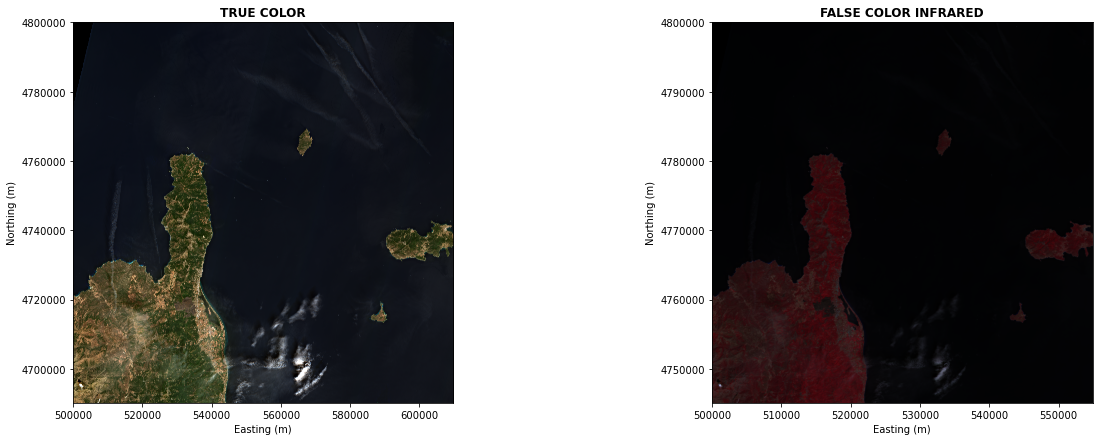

In [3]:
fig, (ax, ay) = plt.subplots(1,2, figsize=(21,7))
show(TCI.read(), ax=ax, transform=TCI.transform,  title = "TRUE COLOR")
ax.set_ylabel("Northing (m)") # (WGS 84 / UTM zone 32N)
ax.set_xlabel("Easting (m)")
ax.ticklabel_format(axis = 'both', style = 'plain')


# Function to normalize false colour infrared image 
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max() 
    return ((array - array_min)/(array_max - array_min))

nir = b8.read(1)
red = b4.read(1)
green = b3.read(1)
nirn = normalize(scipy.ndimage.zoom(nir,0.5))
redn = normalize(scipy.ndimage.zoom(red,0.5))
greenn = normalize(scipy.ndimage.zoom(green,0.5))
FCIR = np.dstack((nirn, redn, greenn))
FCIR = np.moveaxis(FCIR.squeeze(),-1,0)
show(FCIR, ax=ay, transform=TCI.transform, title = "FALSE COLOR INFRARED")
ay.set_ylabel("Northing (m)") # (WGS 84 / UTM zone 32N)
ay.set_xlabel("Easting (m)")
ay.ticklabel_format(axis = 'both', style = 'plain')

## <a id='sentinel2_ndvi'></a>3. Process and view Sentinel-2 data as vegetation and other spectral indices

Vegetation status is a combination of a number of properties of the vegetation related to growth, density, health and environmental factors. By making measurements of surface reflectance in the red and near infrared (NIR) parts of the spectrum optical instruments can summarise crop status through a vegetation index. The red region is related to chlorophyll absorption and the NIR is related to multiple scattering within leaf structures, therefore low red and high NIR represent healthy / dense vegetation. These values are summarised in the commonly used Normalised Difference Vegetation Index (NDVI).

<img src='./img/ndvi.jpg' align='center' width='20%'></img>

We will examine a small subset of the full image were we know differences in vegetation will be present due to natural and anthropogenic processes and calculate the NDVI to show how its value changes. 

We will also calculate a second spectral index, the Normalised Difference Water Index (NDWI), which emphasises water surfaces to compare to NDVI.

To do this we'll first load some vector datasets for an area of interest (AOI) and some field boundaries.

### Open Vector Data

In [4]:
path_shp  = os.path.join(os.getcwd(), 'shp')
aoi = gpd.read_file(os.path.join(path_shp, 'WEkEO-Land-AOI-201223.shp'))
LPSI = gpd.read_file(os.path.join(path_shp, 'LPIS-AOI-201223.shp'))

### Check CRS of Vector Data

Before we can use the vector data we must check the coordinate reference system (CRS) and then transpose them to the same CRS as the Sentinel-2 data. In this case we require all the data to be in the WGS 84 / UTM zone 32N CRS with the EPSG code of 32632.

In [5]:
print(aoi.crs)
print(LPSI.crs)
aoi_proj = aoi.to_crs(epsg=32632) #convert to WGS 84 / UTM zone 32N (Sentinel-2 crs)
LPIS_proj = LPSI.to_crs(epsg=32632)
print("conversion to S2 NDVI crs:")
print(aoi_proj.crs)
print(LPIS_proj.crs)

epsg:4326
epsg:2154
conversion to S2 NDVI crs:
epsg:32632
epsg:32632


### Calculate NDVI from red and near infrared bands

First step is to calculate the NDVI for the whole image using some straightforward band maths and write out the result to a geoTIFF file.

In [ ]:
nir = b8.read()
red = b4.read()
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

meta = b4.meta 
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)
with rio.open(os.path.join(data_path, 'S2_NDVI.tif'), 'w', **meta) as dst:
    dst.write(ndvi.astype(rio.float32))

### Calculate NDWI from green and near infrared bands

The new step is to calculate the NDWI for the whole image using some straightforward band maths and write out the result to a geoTIFF file.

In [ ]:
nir = b8.read()
green = b3.read()
ndwi = (green.astype(float) - nir.astype(float))/(nir+green)

meta = b3.meta 
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)
with rio.open(os.path.join(data_path, 'S2_NDWI.tif'), 'w', **meta) as dst:
    dst.write(ndwi.astype(rio.float32))

### Crop the extent of the NDVI and NDWI images to the AOI

The file produced in the previous step is then cropped using the AOI geometry. 

In [ ]:
with rio.open(os.path.join(data_path, "S2_NDVI.tif")) as src:
    out_image, out_transform = mask(src, aoi_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open(os.path.join(data_path, "S2_NDVI_masked.tif"), "w", **out_meta) as dest:
    dest.write(out_image)   
    
with rio.open(os.path.join(data_path, "S2_NDWI.tif")) as src:
    out_image, out_transform = mask(src, aoi_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open(os.path.join(data_path, "S2_NDWI_masked.tif"), "w", **out_meta) as dest:
    dest.write(out_image)   

### Display NDVI and NDWI for the AOI

The AOI represents an area of northern Corsica centred on the town of Bagnasca. To the west are mountains dominated by forests and woodlands of evergreen sclerophyll oaks which tend to give high values of NDVI intersperse by areas of grassland or bare ground occuring naturally or as a consequnce of forest fires. The patterns are more irregular and follow the terrain and hydrological features. The lowlands to east have been clear of forest for agriculture shown by a fine scale mosaic of regular geometric features representing crop fields with diffrerent NDVIs or the presence of vegetated boundary features. The lower values of NDVI (below zero) in the east are associated with the sea and the large lagoon of the Réserve naturelle de l'étang de Biguglia.

As expected the NDWI gives high values for the open sea and lagoon areas of the image. Interestingly there are relatively high values for some of the fields in the coastal plane suggesting they may be flooded or irrigated. The bare surfaces have NDWI values below zero and the vegetated areas are lower still.

The colour map used to display the NDVI uses a ramp from blue to green to emphasise the increasing density and vigour of vegetation at high NDVI values. If distinction are not so clear the cmap value can be change from "BuGn" or "RdBu" to something more appropriate with reference to the the available colour maps at [Choosing Colormaps in Matplotlib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html).

In [ ]:
ndvi_aoi = rio.open(os.path.join(data_path, 'S2_NDVI_masked.tif'))

fig, (az, ay) = plt.subplots(1,2, figsize=(21, 7))

# use imshow so that we have something to map the colorbar to
image_hidden_1 = az.imshow(ndvi_aoi.read(1), 
                         cmap='BuGn')

# LPIS_proj.plot(ax=ax, facecolor='none', edgecolor='k')

image = show(ndvi_aoi, ax=az, cmap='BuGn', transform=ndvi_aoi.transform, title ="NDVI")

fig.colorbar(image_hidden_1, ax=az)
az.set_ylabel("Northing (m)") #(WGS 84 / UTM zone 32N)
az.set_xlabel("Easting (m)")
az.ticklabel_format(axis = 'both', style = 'plain')

ndwi_aoi = rio.open(os.path.join(data_path, 'S2_NDWI_masked.tif'))

# use imshow so that we have something to map the colorbar to
image_hidden_1 = ay.imshow(ndwi_aoi.read(1), 
                         cmap='RdBu')

# LPIS_proj.plot(ax=ax, facecolor='none', edgecolor='k')

image = show(ndwi_aoi, ax=ay, cmap='RdBu', transform=ndwi_aoi.transform, title ="NDWI")

fig.colorbar(image_hidden_1, ax=ay)
ay.set_ylabel("Northing (m)") #(WGS 84 / UTM zone 32N)
ay.set_xlabel("Easting (m)")
ay.ticklabel_format(axis = 'both', style = 'plain')

### Histogram of NDVI values

If the NDVI values for the area are summarised as a histogram the two main levels of vegetation density / vigour become apprent. On the left of the plot there is a peak between NDVI values of -0.1 and 0.3 for the water and unvegetated areas together (with the water generally lower) and on the right the peak around an NDVI value of 0.8 is the dense forest and vigorous crops. The region in between shows spare vegetation, grassland and crops that are yet to mature. 

In the NDWI histogram there are multiple peaks representing the sea and lagoons, bare surfaes and vegetation respectively. The NDVI and NDWI can be used in combination to characterise regons within satellite images.

In [ ]:
fig, axhist = plt.subplots(1,1)
show_hist(ndvi_aoi, bins=100, masked=False, title='Histogram of NDVI values', facecolor = 'g', ax =axhist)
axhist.set_xlabel('NDVI')
axhist.set_ylabel('number of pixels')
plt.gca().get_legend().remove()

fig, axhist = plt.subplots(1,1)
show_hist(ndwi_aoi, bins=100, masked=False, title='Histogram of NDWI values', facecolor = 'b', ax =axhist)
axhist.set_xlabel('NDWI')
axhist.set_ylabel('number of pixels')
plt.gca().get_legend().remove()

### NDVI index on a cultivation pattern area

We can look in more detail at the agricultural area to see the patterns in the NDVI values caused by differential crop density and growth. As before we load a vector file containing an AOI, subset the original Sentinel-2 NDVI image. This time we over lay a set of field boundaries from the Land Parcel Information System (LPIS) which highlight some of the management units.

This analysis gives us a representation of the biophysical properties of the surface at the time of image acquisition. 

In [ ]:
#Load shapefile of the AOIs

cult_zoom = gpd.read_file(os.path.join(path_shp, 'complex_cultivation_patterns_zoom.shp'))

#Subset the Sentinel-2 NDVI image

with rio.open(os.path.join(data_path, "S2_NDVI.tif")) as src:
    out_image, out_transform = mask(src, cult_zoom.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open(os.path.join(data_path, "NDVI_cultivation_area.tif"), "w", **out_meta) as dest:
    dest.write(out_image.astype(rio.float32))
    
#Display the results with the LPIS

rcParams['axes.titlepad'] = 20 

src_cult = rio.open(os.path.join(data_path, "NDVI_cultivation_area.tif"))

fig, axg = plt.subplots(figsize=(21, 7))

image_hidden_1 = axg.imshow(src_cult.read(1), 
                         cmap='BuGn')

LPIS_proj.plot(ax=axg, facecolor='none', edgecolor='k')

show(src_cult, ax=axg, cmap='BuGn', transform=src_cult.transform, title='NDVI - Complex cultivation patterns')

fig.colorbar(image_hidden_1, ax=axg)

axg.set_ylabel("Northing (m)") #(WGS 84 / UTM zone 32N)
axg.set_xlabel("Easting (m)")

plt.subplots_adjust(bottom=0.1, right=0.6, top=0.9)
axg.ticklabel_format(axis = 'both', style = 'plain')

## <a id='display_clc'></a>4. Read and view the CLC data

The CORINE Land Cover (CLC) inventory has been produced at a European level in 1990, 2000, 2006, 2012, and 2018. It records land cover and land use in 44 classes with a Minimum Mapping Unit (MMU) of 25 hectares (ha) and a minimum feature width of 100 m. The time series of status maps are complemented by change layers, which highlight changes between the land cover land use classes with an MMU of 5 ha. The Eionet network of National Reference Centres Land Cover (NRC/LC) produce the CLC databases at Member State level, which are coordinated and integrated by EEA. CLC is produced by the majority of countries by visual interpretation of high spatial resolution satellite imagery (10 - 30 m spatial resolution). In a few countries semi-automatic solutions are applied, using national in-situ data, satellite image processing, GIS integration and generalisation. CLC has a wide variety of applications, underpinning various policies in the domains of environment, but also agriculture, transport, spatial planning etc.

### Crop the extent of the Corine Land Cover 2018 (CLC 2018) to the AOI and display

As with the Sentinel-2 data it is necesasary to crop the pan-European CLC2018 dataset to be able to review it at the local level. 

### Set up paths to data

In [ ]:
#path to Corine land cover 2018
land_cover_dir = Path(os.path.join(download_dir_path,'u2018_clc2018_v2020_20u1_raster100m/DATA/'))
legend_dir = Path(os.path.join(download_dir_path,'u2018_clc2018_v2020_20u1_raster100m/Legend/'))

#path to the colormap
txt_filename = legend_dir/'CLC2018_CLC2018_V2018_20_QGIS.txt'

### Re-project vector files to the same coordinate system of the CLC 2018

In [ ]:
aoi_3035 = aoi.to_crs(epsg=3035) # EPSG:3035 (ETRS89-extended / LAEA Europe)

### Write CLC 2018 subset

In [ ]:
with rio.open(str(land_cover_dir)+'/U2018_CLC2018_V2020_20u1.tif') as src:
    out_image, out_transform = mask(src, aoi_3035.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform,
                 "dtype": "int8",
                 "nodata":0
                    })
    
with rio.open("CLC_masked/Corine_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

### Set up the legend for the CLC data

As the CLC data is thematic in nature we must set up a legend to be displayed with the results showing the colour, code and definition of each land cover / land use class.

### Read CLC 2018 legend

A text file is availabe which contains the details of the CLC nomenclature for building the legend when displaying CLC.

In [ ]:
### Create colorbar
def parse_line(line):
    _, r, g, b, a, descr = line.split(',')
    return (int(r), int(g), int(b), int(a)), descr.split('\n')[0]

with open(txt_filename, 'r') as txtf:
    lines = txtf.readlines()

legend = {nline+1: parse_line(line) for nline, line in enumerate(lines[:-1])}
legend[0] = parse_line(lines[-1])

#print code and definition of each land cover / land use class
def parse_line_class_list(line):
    class_id, r, g, b, a, descr = line.split(',')
    return (int(class_id), int(r), int(g), int(b), int(a)), descr.split('\n')[0]

with open(txt_filename, 'r') as txtf:
    lines = txtf.readlines()

legend_class = {nline+1: parse_line_class_list(line) for nline, line in enumerate(lines[:-1])}
legend_class[0] = parse_line_class_list(lines[-1])

print('Level 3 classes')
for k, v in sorted(legend_class.items()):
    print(f'{v[0][0]}\t{v[1]}')

### Build the legend for the CLC 2018 in the area of interest

As less than half of the CLC classes are present in the AOI an area specific legend will be built to simplify interpretation.

In [ ]:
#open CLC 2018 subset
cover_land = rio.open("CLC_masked/Corine_masked.tif")

array_rast = cover_land.read(1)

#Set no data value to 0
array_rast[array_rast == -128] = 0

class_aoi = list(np.unique(array_rast))
legend_aoi = dict((k, legend[k]) for k in class_aoi if k in legend)

classes_list =[]
number_list = []
for k, v in sorted(legend_aoi.items()):
    #print(f'{k}:\t{v[1]}')
    classes_list.append(v[1])
    number_list.append(k)

class_dict = dict(zip(classes_list,number_list))

#create the colobar
corine_cmap_aoi= ListedColormap([np.array(v[0]).astype(float)/255.0 for k, v in sorted(legend_aoi.items())])

# Map the values in [0, 22]
new_dict = dict()
for i, v in enumerate(class_dict.items()):
    new_dict[v[1]] = (v[0], i)

fun = lambda x : new_dict[x][1]
matrix = map(np.vectorize(fun), array_rast)
matrix = np.matrix(list(matrix))

### Display the CLC2018 data for the AOI

The thematic nature and the 100 m spatial resolution of the CLC2018 give a very different view of the landscape compared to the Sentinel-2 data. CLC2018 offers a greater information content as it is a combination of multiple images, ancillary data and human interpretation while Sentinel-2 offers great spatial information for one instance in time. 

The separation of the mountains with woodland habitats and the coastal planes with agriculture can be clearly seen marked by a line of urban areas. The mountains are dominated by deciduous woodland, sclerophyllous vegetation and transitional scrub. The coastal planes consist of various types of agricultural land associated with small field farming practices.

The most striking feature of the CLC2018 data is a large burnt area which resulted from a major forest fire in July 2017.

In [ ]:
#plot
fig2, axs2 = plt.subplots(figsize=(10,10),sharey=True)
show(matrix, ax=axs2, cmap=corine_cmap_aoi, transform = cover_land.transform, title = "Corine Land Cover 2018")
norm = colors.BoundaryNorm(np.arange(corine_cmap_aoi.N + 1), corine_cmap_aoi.N + 1)
cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=corine_cmap_aoi), ax=axs2, fraction=0.03)
cb.set_ticks([x+.5 for x in range(-1,22)]) # move the marks to the middle
cb.set_ticklabels(list(class_dict.keys())) # label the colors
axs2.ticklabel_format(axis = 'both', style = 'plain')
axs2.set_ylabel("Northing (m)") #EPSG:3035 (ETRS89-extended / LAEA Europe)
axs2.set_xlabel("Easting (m)")

## <a id='CLC_burn_NDVI'></a>5. CLC2018 burnt area in the Sentinel-2 NDVI data

The area of the burn will have a very low NDVI compared to the surounding unburnt vegetation. The boundary of the burn can be easily seen as well as remnants of the original vegetation which have survived the burn.

In [ ]:
#Load shapefile of the AOIs and check the crs

burnt_aoi = gpd.read_file(os.path.join(path_shp, 'burnt_area.shp'))
print("vector file crs:")
print(burnt_aoi.crs)

burnt_aoi_32632 = burnt_aoi.to_crs(epsg=32632) #Sentinel-2 NDVI crs
print("conversion to S2 NDVI crs:")
print(burnt_aoi_32632.crs)

### Crop the extent of the NDVI image for burnt area

In [ ]:
with rio.open(os.path.join(data_path, 'S2_NDVI_masked.tif')) as src:
    out_image, out_transform = mask(src, burnt_aoi_32632.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open(os.path.join(data_path, "NDVI_burnt_area.tif"), "w", **out_meta) as dest:
    dest.write(out_image)


### Crop the extent of the CLC 2018 for burnt area

In [ ]:
#open CLC 2018 subset

cover_land = rio.open("CLC_masked/Corine_masked.tif")

print(cover_land.crs) #CLC 2018 crs
burn_aoi_3035 = burnt_aoi.to_crs(epsg=3035) #conversion to CLC 2018 crs

with rio.open(str(land_cover_dir)+'/U2018_CLC2018_V2020_20u1.tif') as src:
    out_image, out_transform = mask(src, burn_aoi_3035.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],"width": out_image.shape[2],
                 "transform": out_transform,
                 "dtype": "int8",
                 "nodata":0
                    })
    
with rio.open("CLC_masked/Corine_burnt_area.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
# Re-project S2 NDVI image to CLC 2018 crs

clc_2018_burnt_aoi = rio.open("CLC_masked/Corine_burnt_area.tif")
dst_crs = clc_2018_burnt_aoi.crs


with rio.open(os.path.join(data_path, "NDVI_burnt_area.tif")) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(os.path.join(data_path, "NDVI_burnt_area_EPSG_3035.tif"), 'w', **kwargs) as dst:
        reproject(source=rio.band(src,1),
                destination=rio.band(dst,1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

### Display NDVI index on the AOIs

In [ ]:
# Build the legend for the CLC 2018 in the area of interest

array_rast_b = clc_2018_burnt_aoi.read(1)

#Set no data value to 0
array_rast_b[array_rast_b == -128] = 0

class_aoi_b = list(np.unique(array_rast_b))
legend_aoi_b = dict((k, legend[k]) for k in class_aoi_b if k in legend)
classes_list_b =[]
number_list_b = []

for k, v in sorted(legend_aoi_b.items()):
    #print(f'{k}:\t{v[1]}')
    classes_list_b.append(v[1])
    number_list_b.append(k)

class_dict_b = dict(zip(classes_list_b,number_list_b))
#create the colobar
corine_cmap_aoi_b= ListedColormap([np.array(v[0]).astype(float)/255.0 for k, v in sorted(legend_aoi_b.items())])

# Map the values in [0, 22]
new_dict_b = dict()
for i, v in enumerate(class_dict_b.items()):
    new_dict_b[v[1]] = (v[0], i)

fun_b = lambda x : new_dict_b[x][1]
matrix_b = map(np.vectorize(fun_b), array_rast_b)
matrix_b = np.matrix(list(matrix_b))


#Plot

rcParams['axes.titlepad'] = 20 
src_burnt = rio.open(os.path.join(data_path, "NDVI_burnt_area_EPSG_3035.tif"))

fig_b, (axr_b, axg_b) = plt.subplots(1,2, figsize=(25, 8))

image_hidden_1_b = axr_b.imshow(src_burnt.read(1), 
                         cmap='BuGn')

show(src_burnt, ax=axr_b, cmap='BuGn', transform=src_burnt.transform, title='NDVI - Burnt area')
show(matrix_b, ax=axg_b, cmap=corine_cmap_aoi_b, transform=clc_2018_burnt_aoi.transform, title='CLC 2018 - Burnt area')

fig_b.colorbar(image_hidden_1_b, ax=axr_b)
plt.tight_layout(h_pad=1.0)

norm = colors.BoundaryNorm(np.arange(corine_cmap_aoi_b.N + 1), corine_cmap_aoi_b.N + 1)
cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=corine_cmap_aoi_b), ax=axg_b, fraction=0.03)
cb.set_ticks([x+.5 for x in range(-1,6)]) # move the marks to the middle
cb.set_ticklabels(list(class_dict_b.keys())) # label the colors
axg_b.ticklabel_format(axis = 'both', style = 'plain')


axr_b.set_ylabel("Northing (m)") #(WGS 84 / UTM zone 32N)
axr_b.set_xlabel("Easting (m)")
axg_b.set_ylabel("Northing (m)") #(WGS 84 / UTM zone 32N)
axg_b.set_xlabel("Easting (m)")

axr_b.ticklabel_format(axis = 'both', style = 'plain')
axg_b.ticklabel_format(axis = 'both', style = 'plain')
plt.tight_layout(h_pad=1.0)


<hr>

<p><img src='./img/all_partners_wekeo_2.png' align='left' alt='Logo EU Copernicus' width='100%'></img></p>